### Data-vector blinding for the power spectrum multipoles

Example notebook showing how to implement the data-vector level blinding for the galaxy power spectrum multipoles.

In [1]:
import sys
from desiblind import TracerPowerSpectrumMultipolesBlinder

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from desilike.samples import plotting
%matplotlib inline
%config InlineBackend.figure_format='retina'

sys.path.insert(0, '../scripts')
from fs_likelihood import get_theory, get_tracer_zrange, get_synthetic_data, get_fit_fn

def sample_from_gaussian(mean, covariance, size=1, seed=42):
    """Sample from a multivariate Gaussian distribution."""
    rng = np.random.RandomState(seed=seed)
    return rng.multivariate_normal(mean, covariance, size=size)


The blinding procedure does the following:

$P_{\rm blind}(k) = P(k) - W(k, k') P_{\rm ref}(k') + W(k, k') P_{\rm shift}(k')$,

where $P_{\rm ref}(k)$ is computed with a *reference* cosmology (reasonably a good match to the data), while 
$P_{\rm shift}(k)$ is computed with a *shift* cosmology (the blinding cosmology).

In [2]:
# We read the reference parameters from a joint full-shape fit to all GQC tracers
from desilike.samples import Profiles, Chain

profiles = Profiles.load(get_fit_fn('profiles'))
bestfit = profiles.bestfit.choice(index='argmax', input=True)
bestfit = {name: float(value) for name, value in bestfit.items()}

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


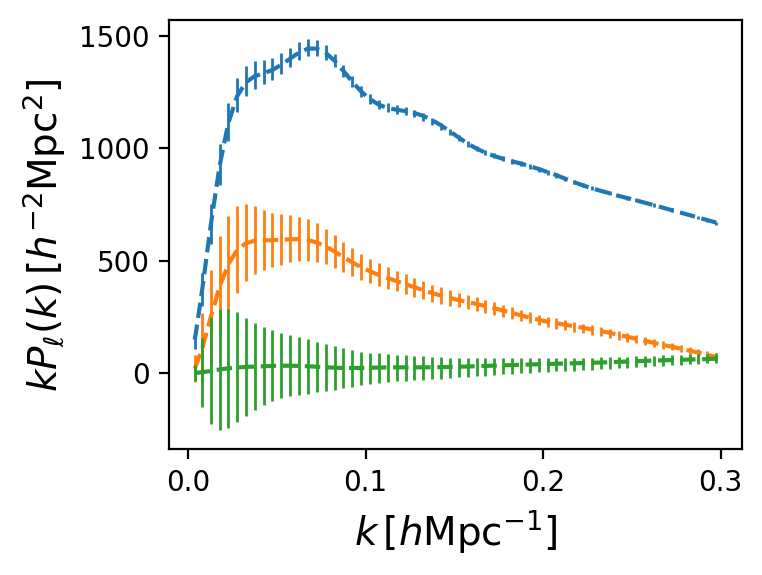

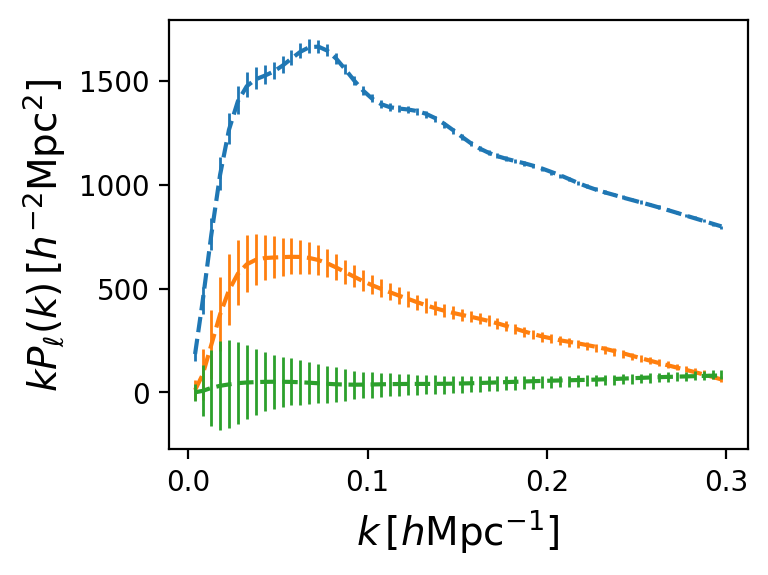

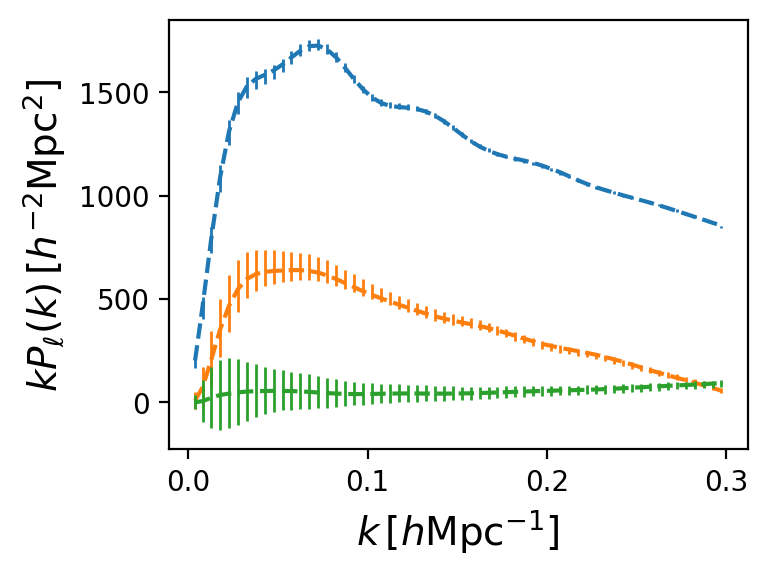

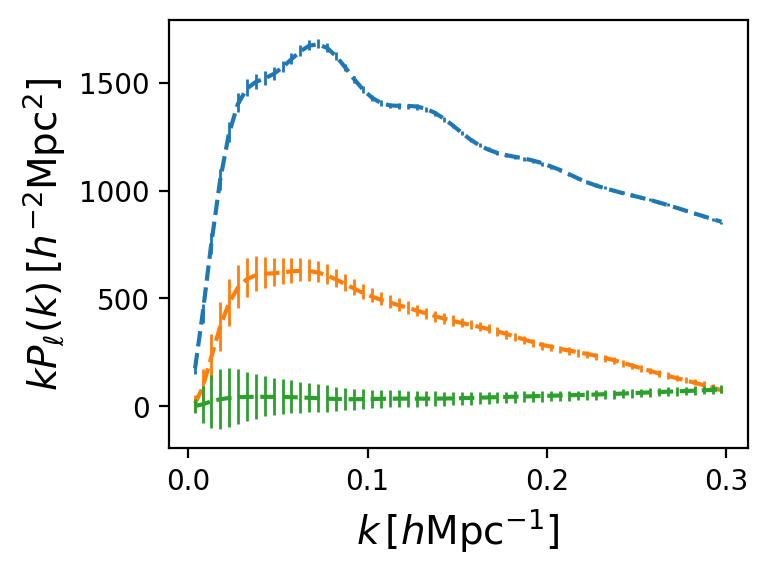

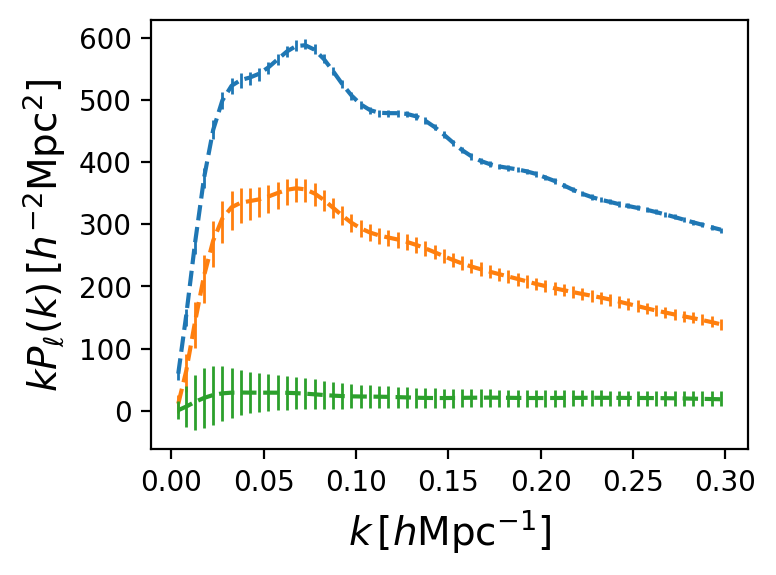

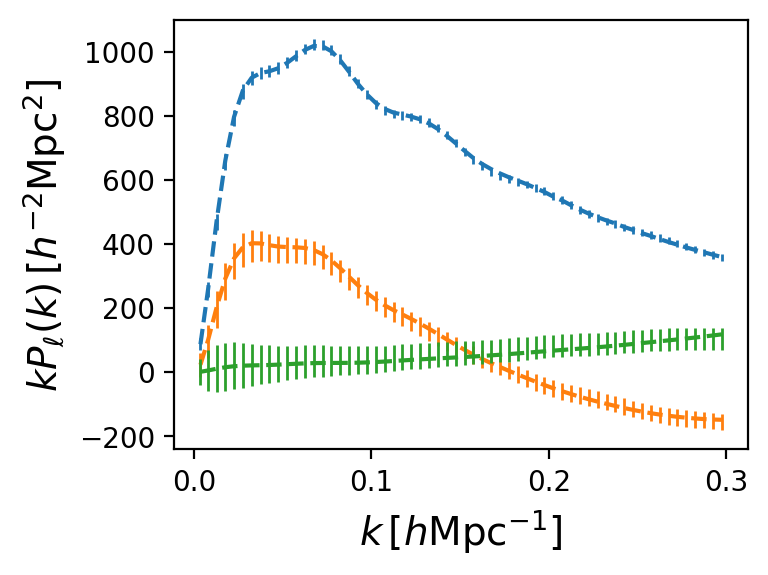

In [3]:
# we instantiate TracerPowerSpectrumMultipolesBlinder, which will provide
# the necessary tools to apply the blinding. We then loop over tracers
# and add their likelihood to the blinder.

cosmo_params = {name: value for name, value in bestfit.items() if '.' not in name}
nuisance_params = {name: value for name, value in bestfit.items() if name not in cosmo_params}

blinder = TracerPowerSpectrumMultipolesBlinder()

tracers = ['BGS_z0', 'LRG_z0', 'LRG_z1', 'LRG_z2', 'ELG_z1', 'QSO_z0']

for namespace in tracers:
    tracer, zrange = get_tracer_zrange(namespace)
    data, covariance, window = get_synthetic_data(tracer=tracer, zrange=zrange, region='GCcomb', ells=[0, 2, 4],
                                                  weights='default_fkp', klim=(0., 0.3), rebin=5)
    theory = get_theory(z=window.theory.get(ells=0).z, tracer=tracer)  # FIXME
    theory.init.update(k=window.theory.get(ells=0).coords('k'), shotnoise=data.get(ells=0).values('shotnoise').mean())
    params = cosmo_params | {param.split('.')[-1]: value for param, value in nuisance_params.items() if param.startswith(namespace)}
    spectrum = theory(**params)
    observable = window.dot(np.ravel(spectrum), return_type=None, zpt=False)

    if True:
        ax = fig, ax = plt.subplots(figsize=(4, 3))
        for ill, ell in enumerate(observable.ells):
            color = f'C{ill:d}'
            pole = observable.get(ells=ell)
            ax.plot(k:=pole.coords('k'), k * pole.value(), color=color, linestyle='--')
            pole = data.get(ells=ell)
            std = covariance.at.observable.get(ells=ell).std()
            ax.errorbar(k:=pole.coords('k'), k * pole.value(), k * std, color=color, ms=2.5, ls='none', elinewidth=1.0)
        ax.set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$', fontsize=14)
        ax.set_ylabel(r'$k P_\ell(k)\,[h^{-2}{\rm Mpc}^{2}]$', fontsize=14)
        plt.tight_layout()
        plt.show()

    blinder.add_observable(name=namespace, data=observable, covariance=covariance)


In [4]:
chain = Chain.concatenate([Chain.load(fn).ravel()[::1] for fn in get_fit_fn('chains', sampler_name='mcmc')[1:4]])


In [5]:
# %matplotlib inline
# plotting.plot_triangle(chain, params=['omega_b', 'omega_cdm', 'sigma8_m', 'h', 'n_s'], title_limit=1)
# # plotting.plot_triangle(chain, params=['BGS_z0.alpha0p', 'BGS_z0.alpha2p', 'BGS_z0.alpha4p'], title_limit=1)

# # plt.savefig('posterior.pdf')
# plt.show()

In [6]:
# we now apply the blinding to each tracer. the "blinded_data" are provided
# to the .set_blinded_data method.

# cosmo_param_names = [name for name in chain.params(input=True).keys() if '.' not in name]
cosmo_param_names = ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s']
nuisance_param_names = [name for name in chain.params(input=True).keys() if name not in cosmo_param_names]

samples = sample_from_gaussian(
        mean=[bestfit[name] for name in [*cosmo_param_names]],
        covariance=chain.covariance([*cosmo_param_names]) * 4,
        size=100,
    )

samples = [dict(zip([*cosmo_param_names], sample)) | {name: bestfit[name] for name in nuisance_param_names} for sample in samples]

for namespace in tracers:
    tracer, zrange = get_tracer_zrange(namespace)
    data, covariance, window = get_synthetic_data(tracer=tracer, zrange=zrange, region='GCcomb', ells=[0, 2, 4],
                                                  weights='default_fkp', klim=(0., 0.3), rebin=5)
    theory = get_theory(z=window.theory.get(ells=0).z, tracer=tracer)
    theory.init.update(k=window.theory.get(ells=0).coords('k'), shotnoise=data.get(ells=0).values('shotnoise').mean())

    for sample in samples:
        these_nuisance_param_names = [name for name in sample.keys() if name.startswith(namespace)]
        params = {name.split('.')[-1]: sample[name] for name in [*cosmo_param_names, *these_nuisance_param_names]}

        spectrum = theory(**params)
        observable = window.dot(np.ravel(spectrum), return_type=None, zpt=False)

        # if True:
        #     ax = fig, ax = plt.subplots(figsize=(4, 3))
        #     for ill, ell in enumerate(observable.ells):
        #         color = f'C{ill:d}'
        #         pole = observable.get(ells=ell)
        #         ax.plot(k:=pole.coords('k'), k * pole.value(), color=color, linestyle='--')
        #         pole = data.get(ells=ell)
        #         std = covariance.at.observable.get(ells=ell).std()
        #         ax.errorbar(k:=pole.coords('k'), k * pole.value(), k * std, color=color, ms=2.5, ls='none', elinewidth=1.0)
        #     ax.set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$', fontsize=14)
        #     ax.set_ylabel(r'$k P_\ell(k)\,[h^{-2}{\rm Mpc}^{2}]$', fontsize=14)
        #     plt.tight_layout()
        #     plt.show()

        blinder.set_blinded_data(namespace, blinded_data=observable)

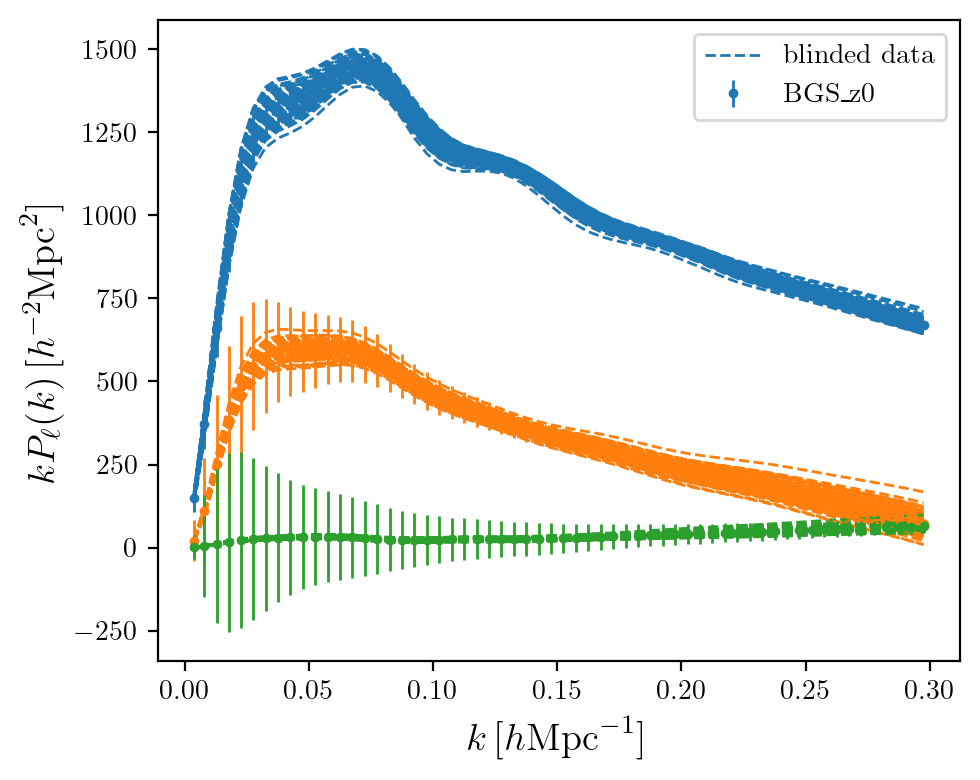

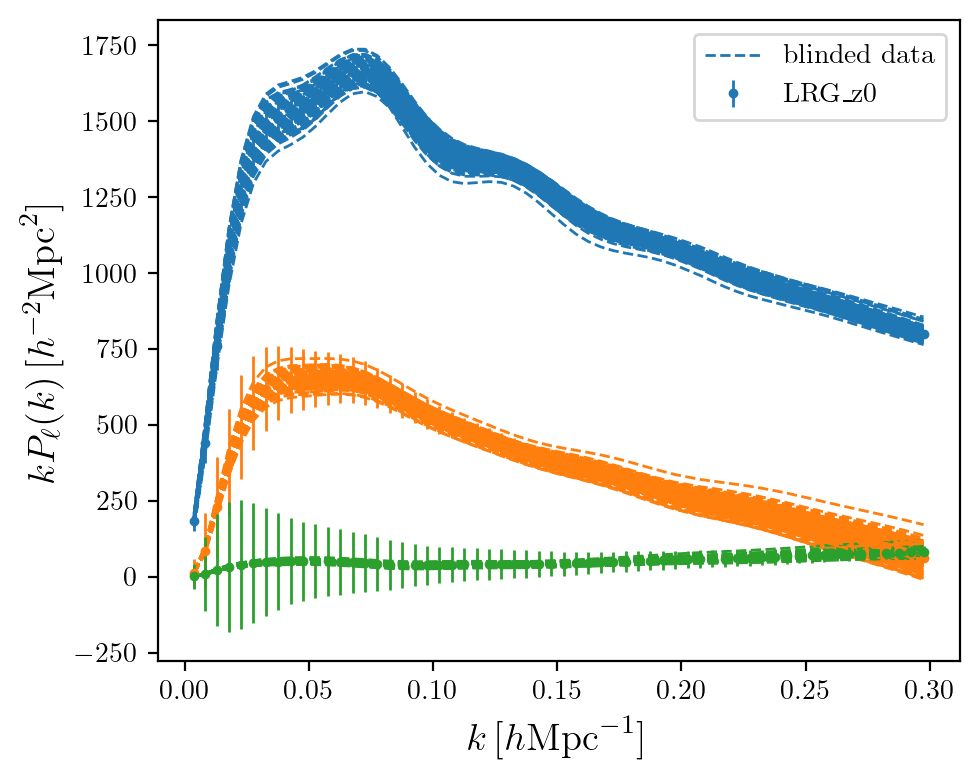

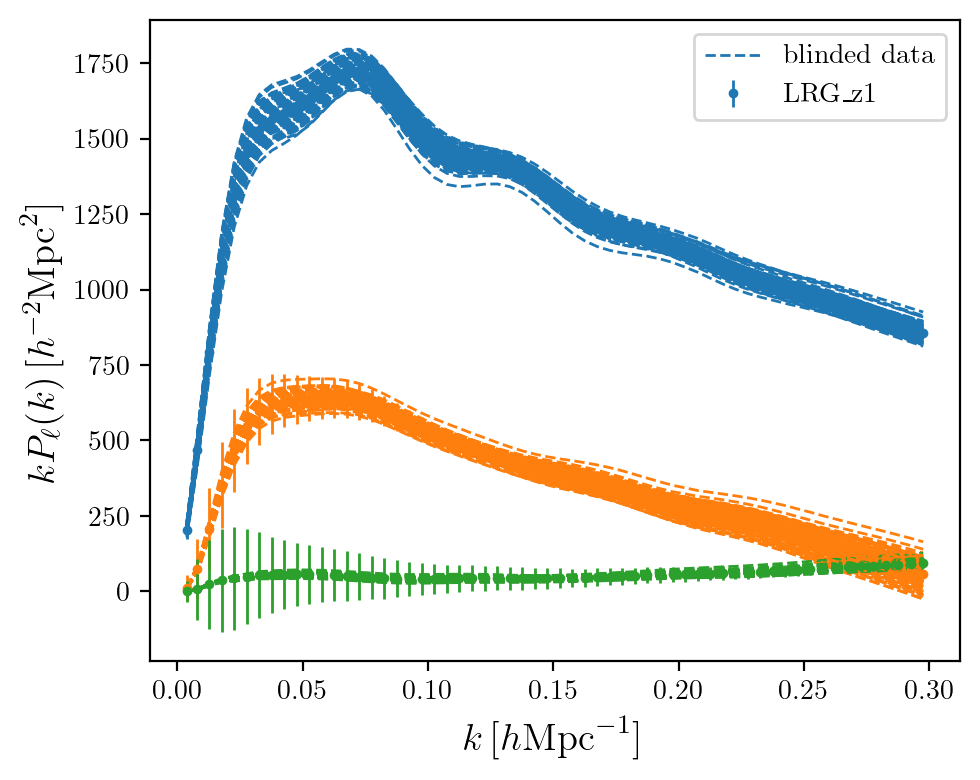

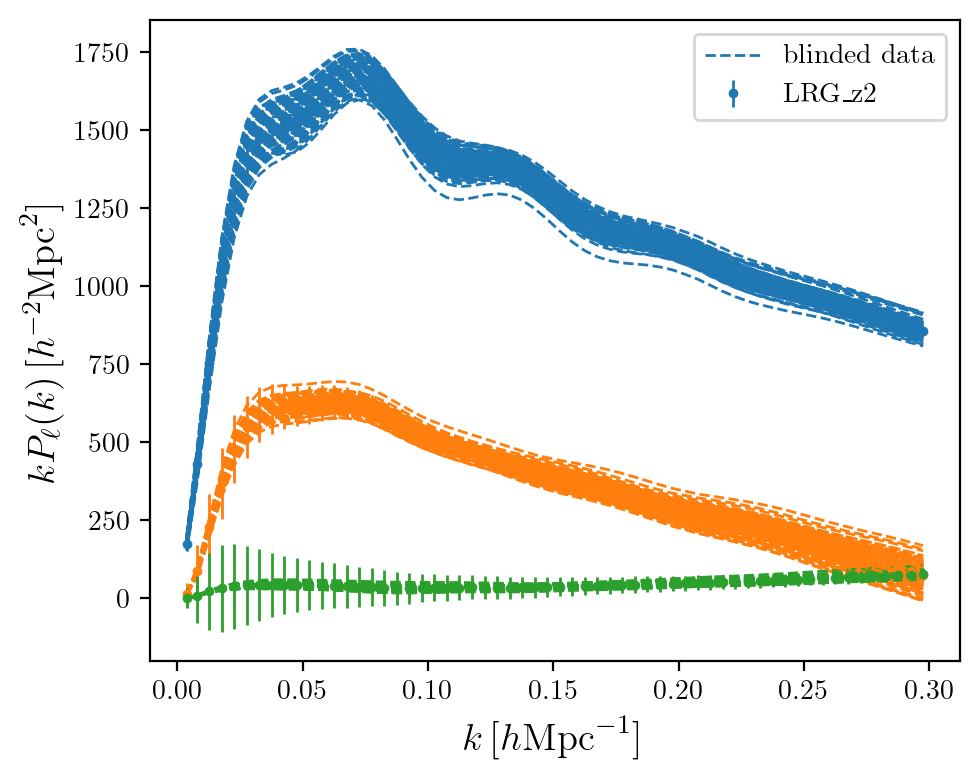

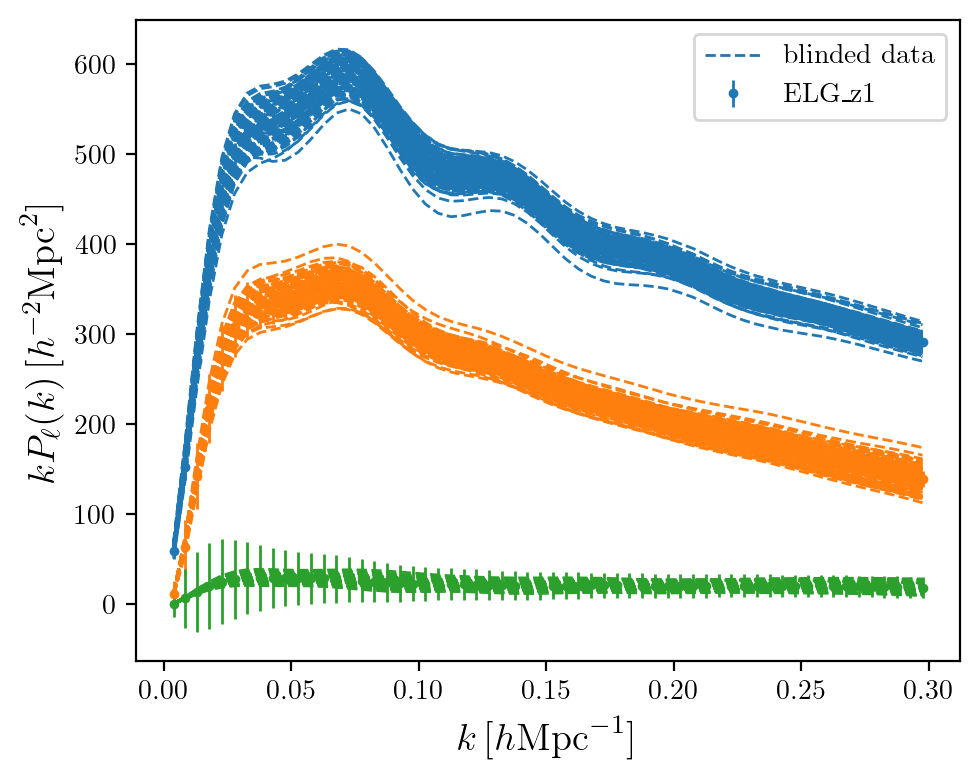

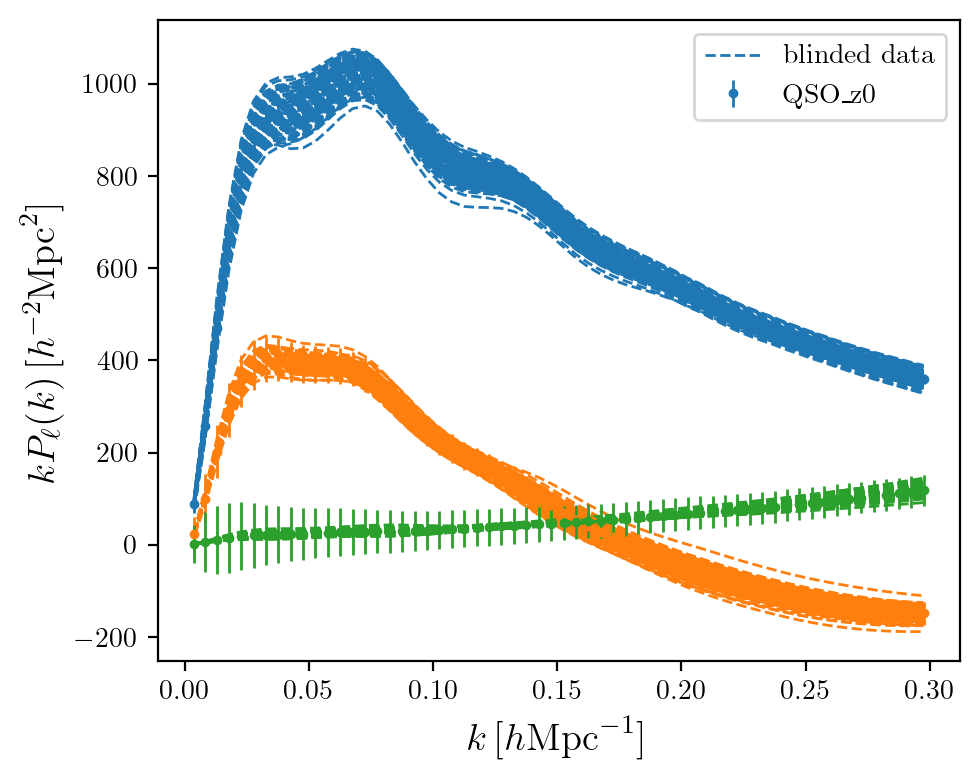

In [7]:
# we can plot the original and blinded data, together with the reference theory.
# blinded_ids specify which blinding realization we want to show
for namespace in ['BGS_z0', 'LRG_z0', 'LRG_z1', 'LRG_z2', 'ELG_z1', 'QSO_z0']:
    fig, ax = blinder.plot_observables(name=namespace, show_blinded=True, blinded_ids=list(range(100)))
    plt.savefig(f'fig/blinding_shifts_{namespace}.png', dpi=300)
    plt.show()

In [8]:
# we save the shifts that are needed to blind the measurements to disk.
# this will then allow us to use those shifts to blind any input data
# without having to go through all the trouble we set up above
blinder.write_blinded_shifts()

In [9]:
len(blinder.observables[0].blinded_data)

100

In [10]:
# load the shifts and use a high-level method that blinds input data.

name = 'LRG_z0'
tracer, zrange = get_tracer_zrange(name)

ells = [0, 2, 4]
observable, covariance, window = get_synthetic_data(
    tracer=tracer,
    zrange=zrange,
    region='GCcomb',
    ells=ells
)

poles = [observable.get(ell) for ell in ells]
k = poles[0].coords('k')
poles = [pole.value() for pole in poles]

blinded_data = TracerPowerSpectrumMultipolesBlinder.apply_blinding(
    name=name,
    k=k,
    data=poles,
    ells=ells,
)
blinded_data2 = TracerPowerSpectrumMultipolesBlinder.apply_blinding(
    name=name,
    data=observable,
)
assert np.allclose(blinded_data2.value(), np.ravel(blinded_data))

In [11]:
unblinded_data = TracerPowerSpectrumMultipolesBlinder.remove_blinding(
    name=name,
    k=k,
    data=blinded_data,
    ells=ells,
    force=True,
)

assert np.allclose(np.ravel(unblinded_data), np.ravel(poles))